# Import Required Libraries

In [1]:
import sys
sys.path.insert(0, '../../src')
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from WSMBSS import *
from general_utils import *
from dsp_utils import *
from bss_utils import *
from numba_utils import *
from visualization_utils import *

import pylab as pl
import warnings

warnings.filterwarnings("ignore")
# np.random.seed(874)
# %load_ext autoreload
# %autoreload 2
notebook_name = "Nonnegative_Sparse"

# Source Generation and Mixing Scenario

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.003231486357098


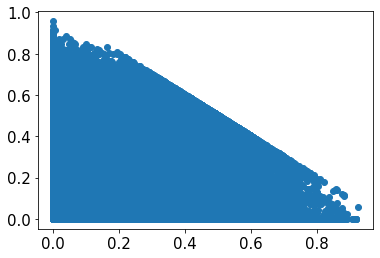

In [2]:
NumberofSources = 5
NumberofMixtures = 10
N = 5 * 1e5
S = 2 * np.random.uniform(size=(NumberofSources, int(N))) - 1
S = ProjectRowstoL1NormBall(S.T).T
S = S * (S >= 0)

INPUT_STD = 0.5
A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)
SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0, :], S[2, :])
plt.show()

# Visualize Generated Sources and Mixtures

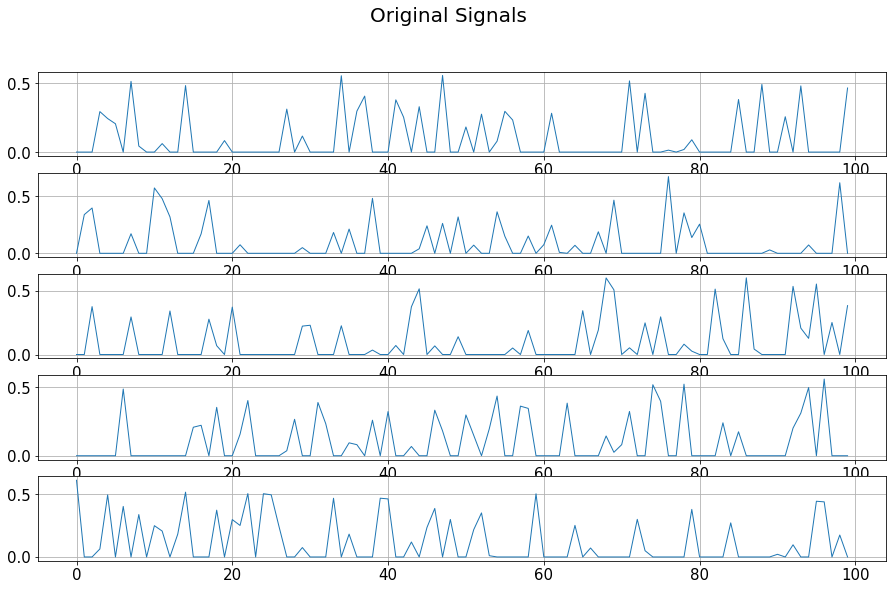

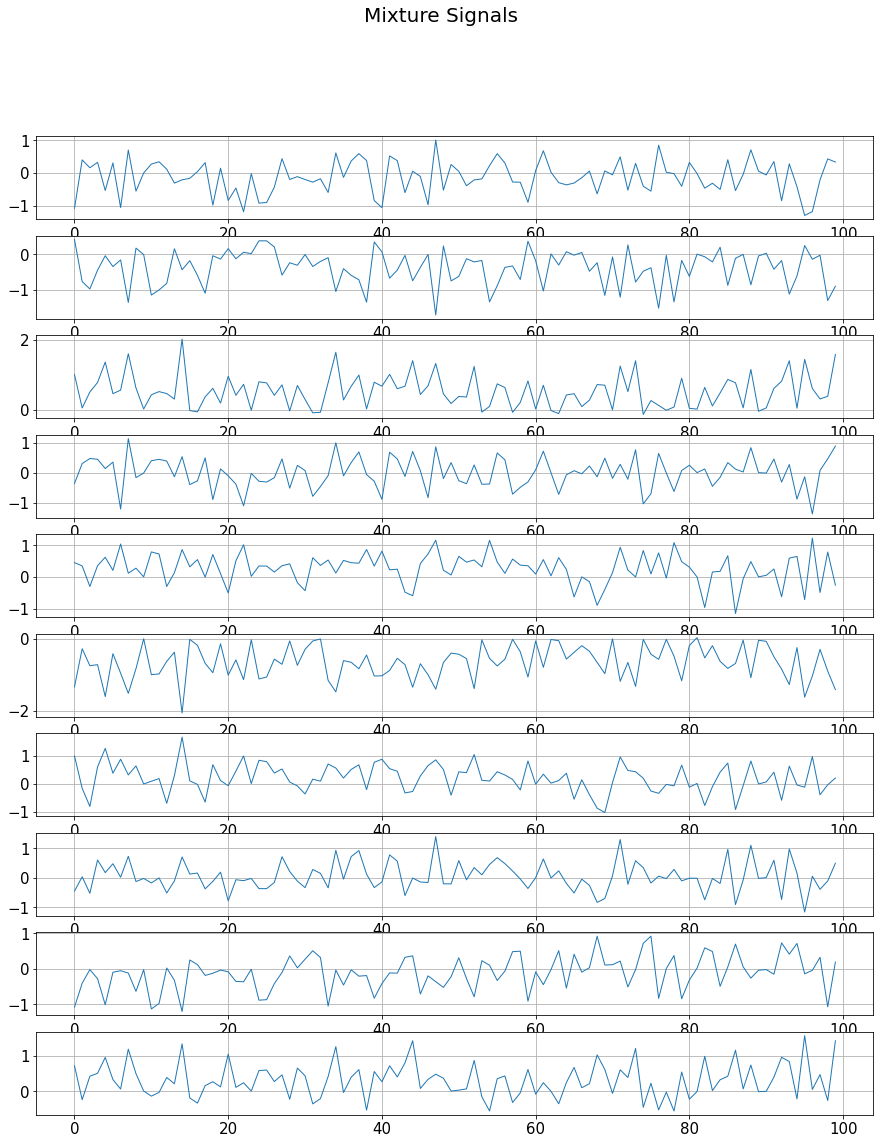

In [3]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
MUS = 0.25

gammaM_start = [MUS, MUS]
gammaM_stop = [1e-3, 1e-3]
gammaW_start = [MUS, MUS]
gammaW_stop = [1e-3, 1e-3]

OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS = 3000
LayerGains = [8, 1]
LayerMinimumGains = [1e-6, 1]
LayerMaximumGains = [1e6, 1.001]
WScalings = [0.0033, 0.0033]
GamScalings = [0.02, 0.02]
zeta = 1e-4
beta = 0.5
muD = [20, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]

# Run WSM Algorithm on Mixture Signals

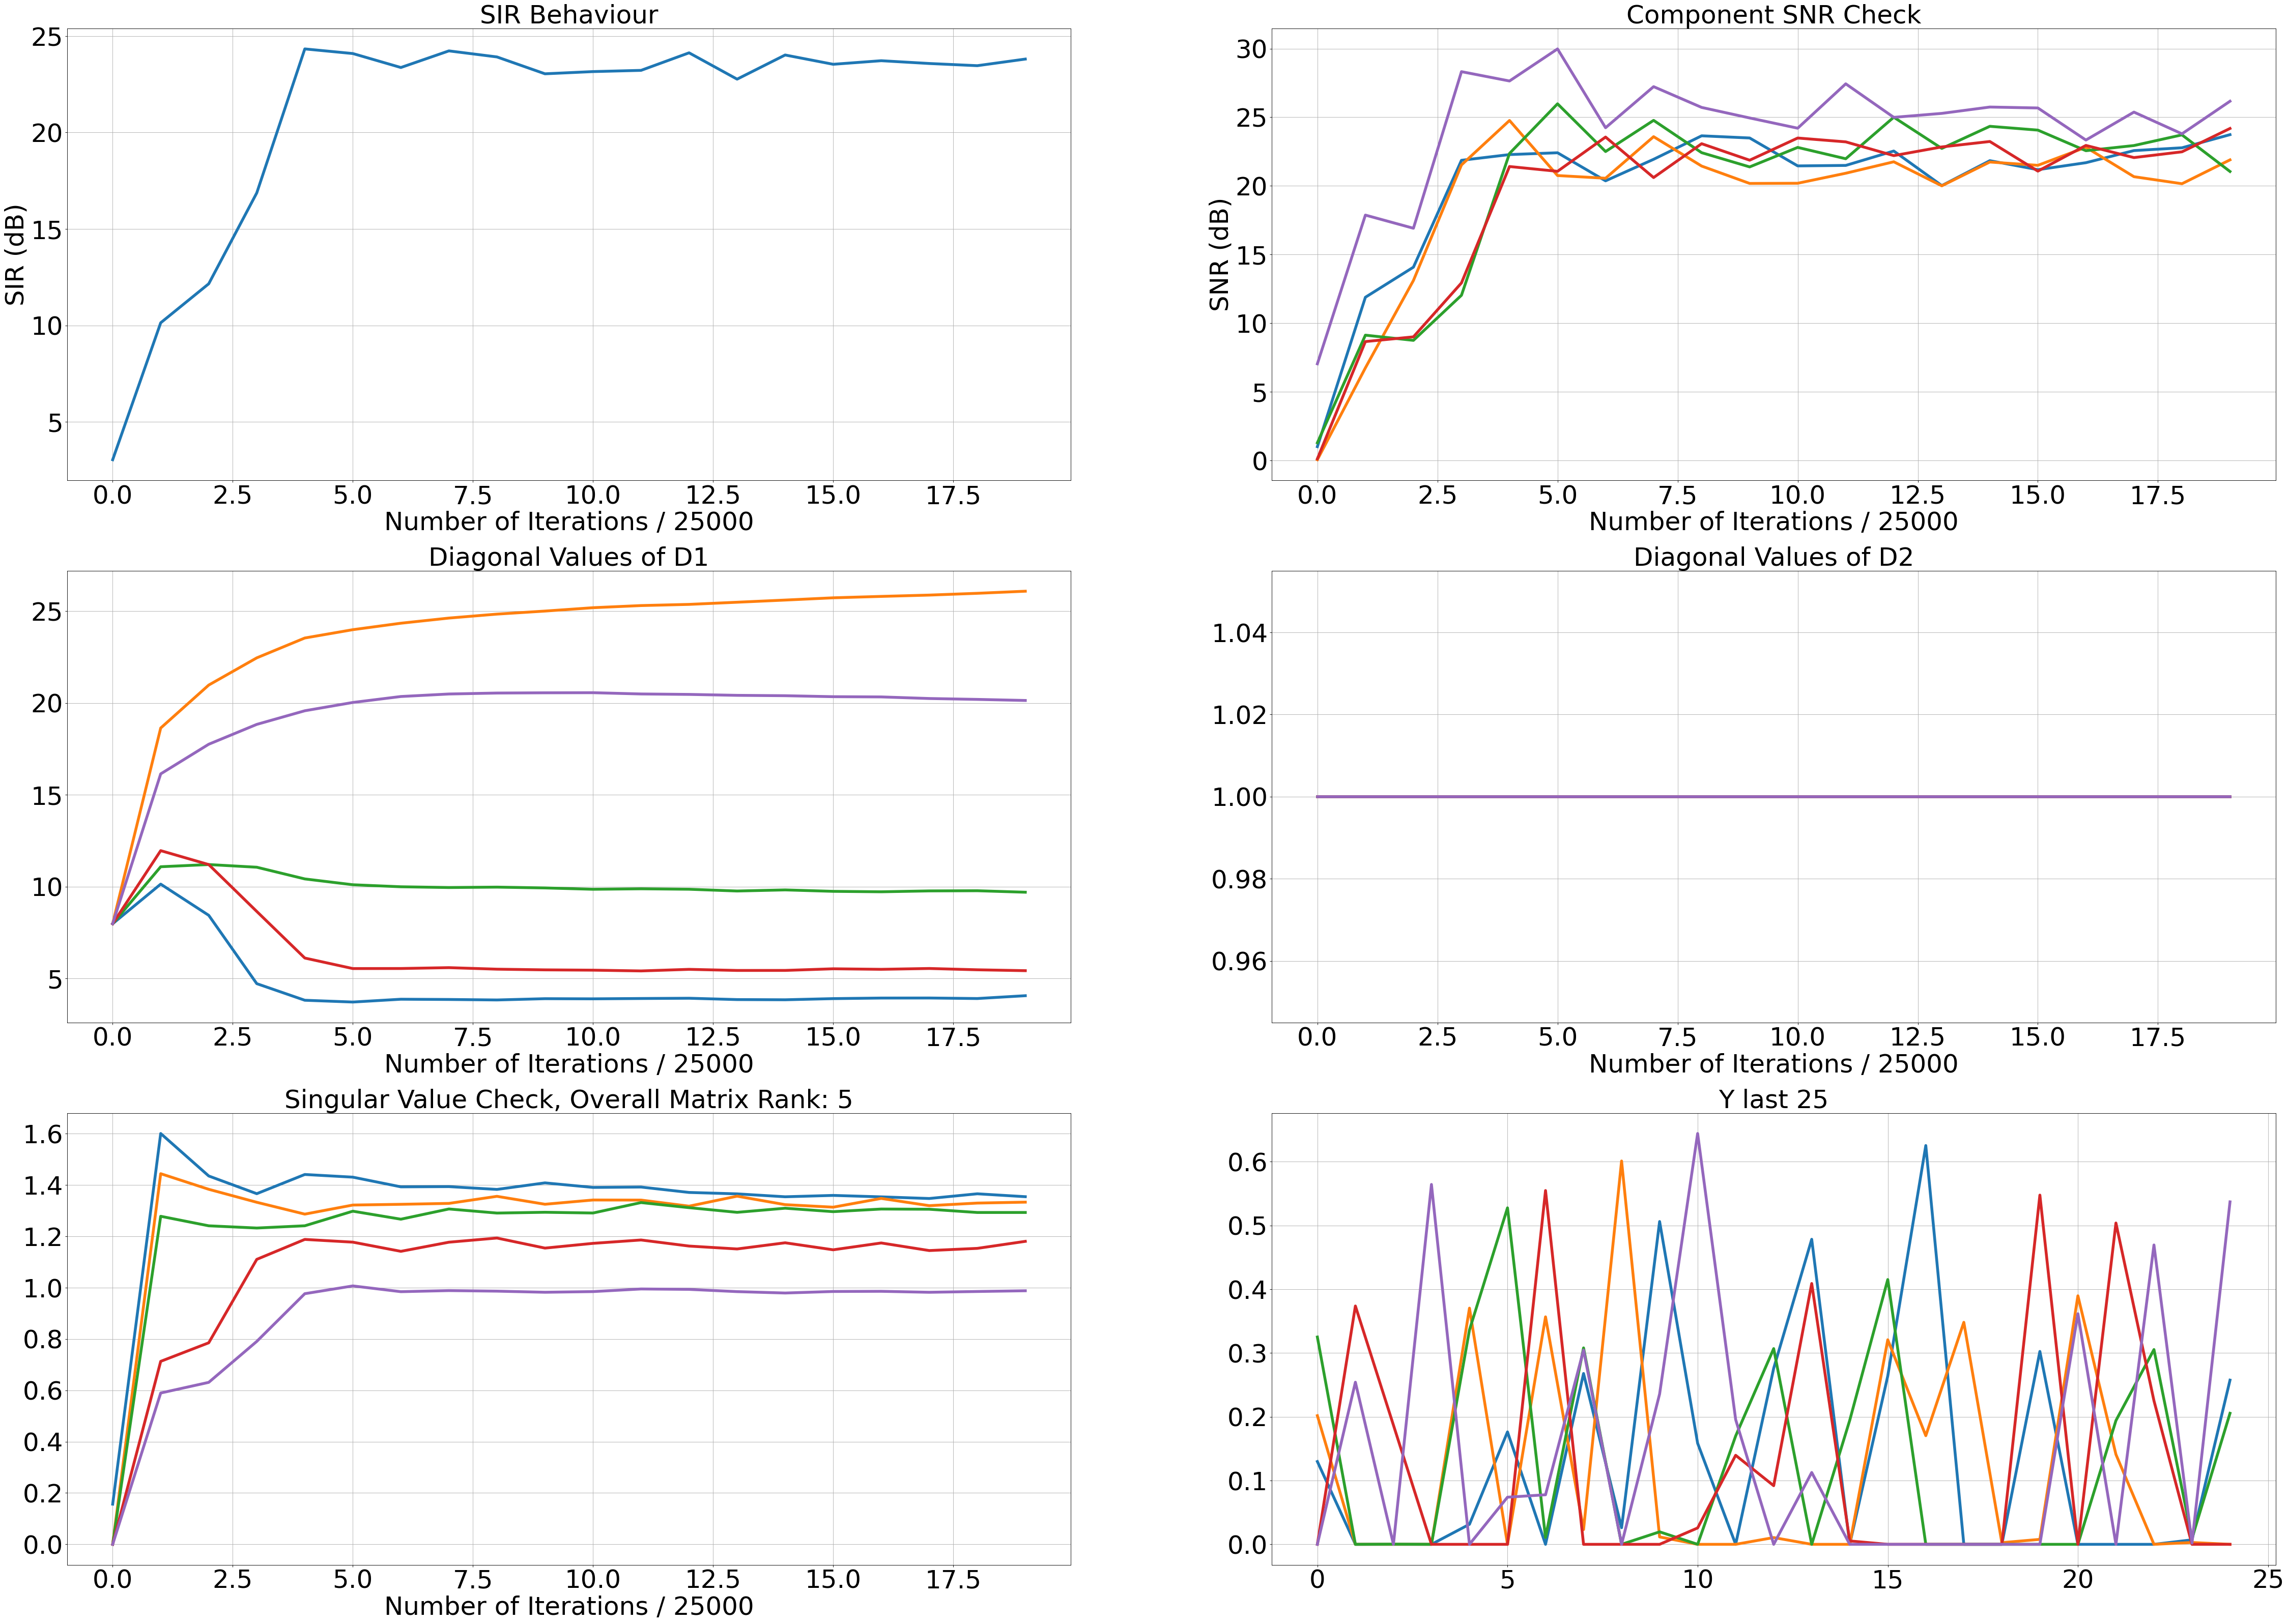

100%|██████████| 500000/500000 [04:22<00:00, 1905.14it/s]


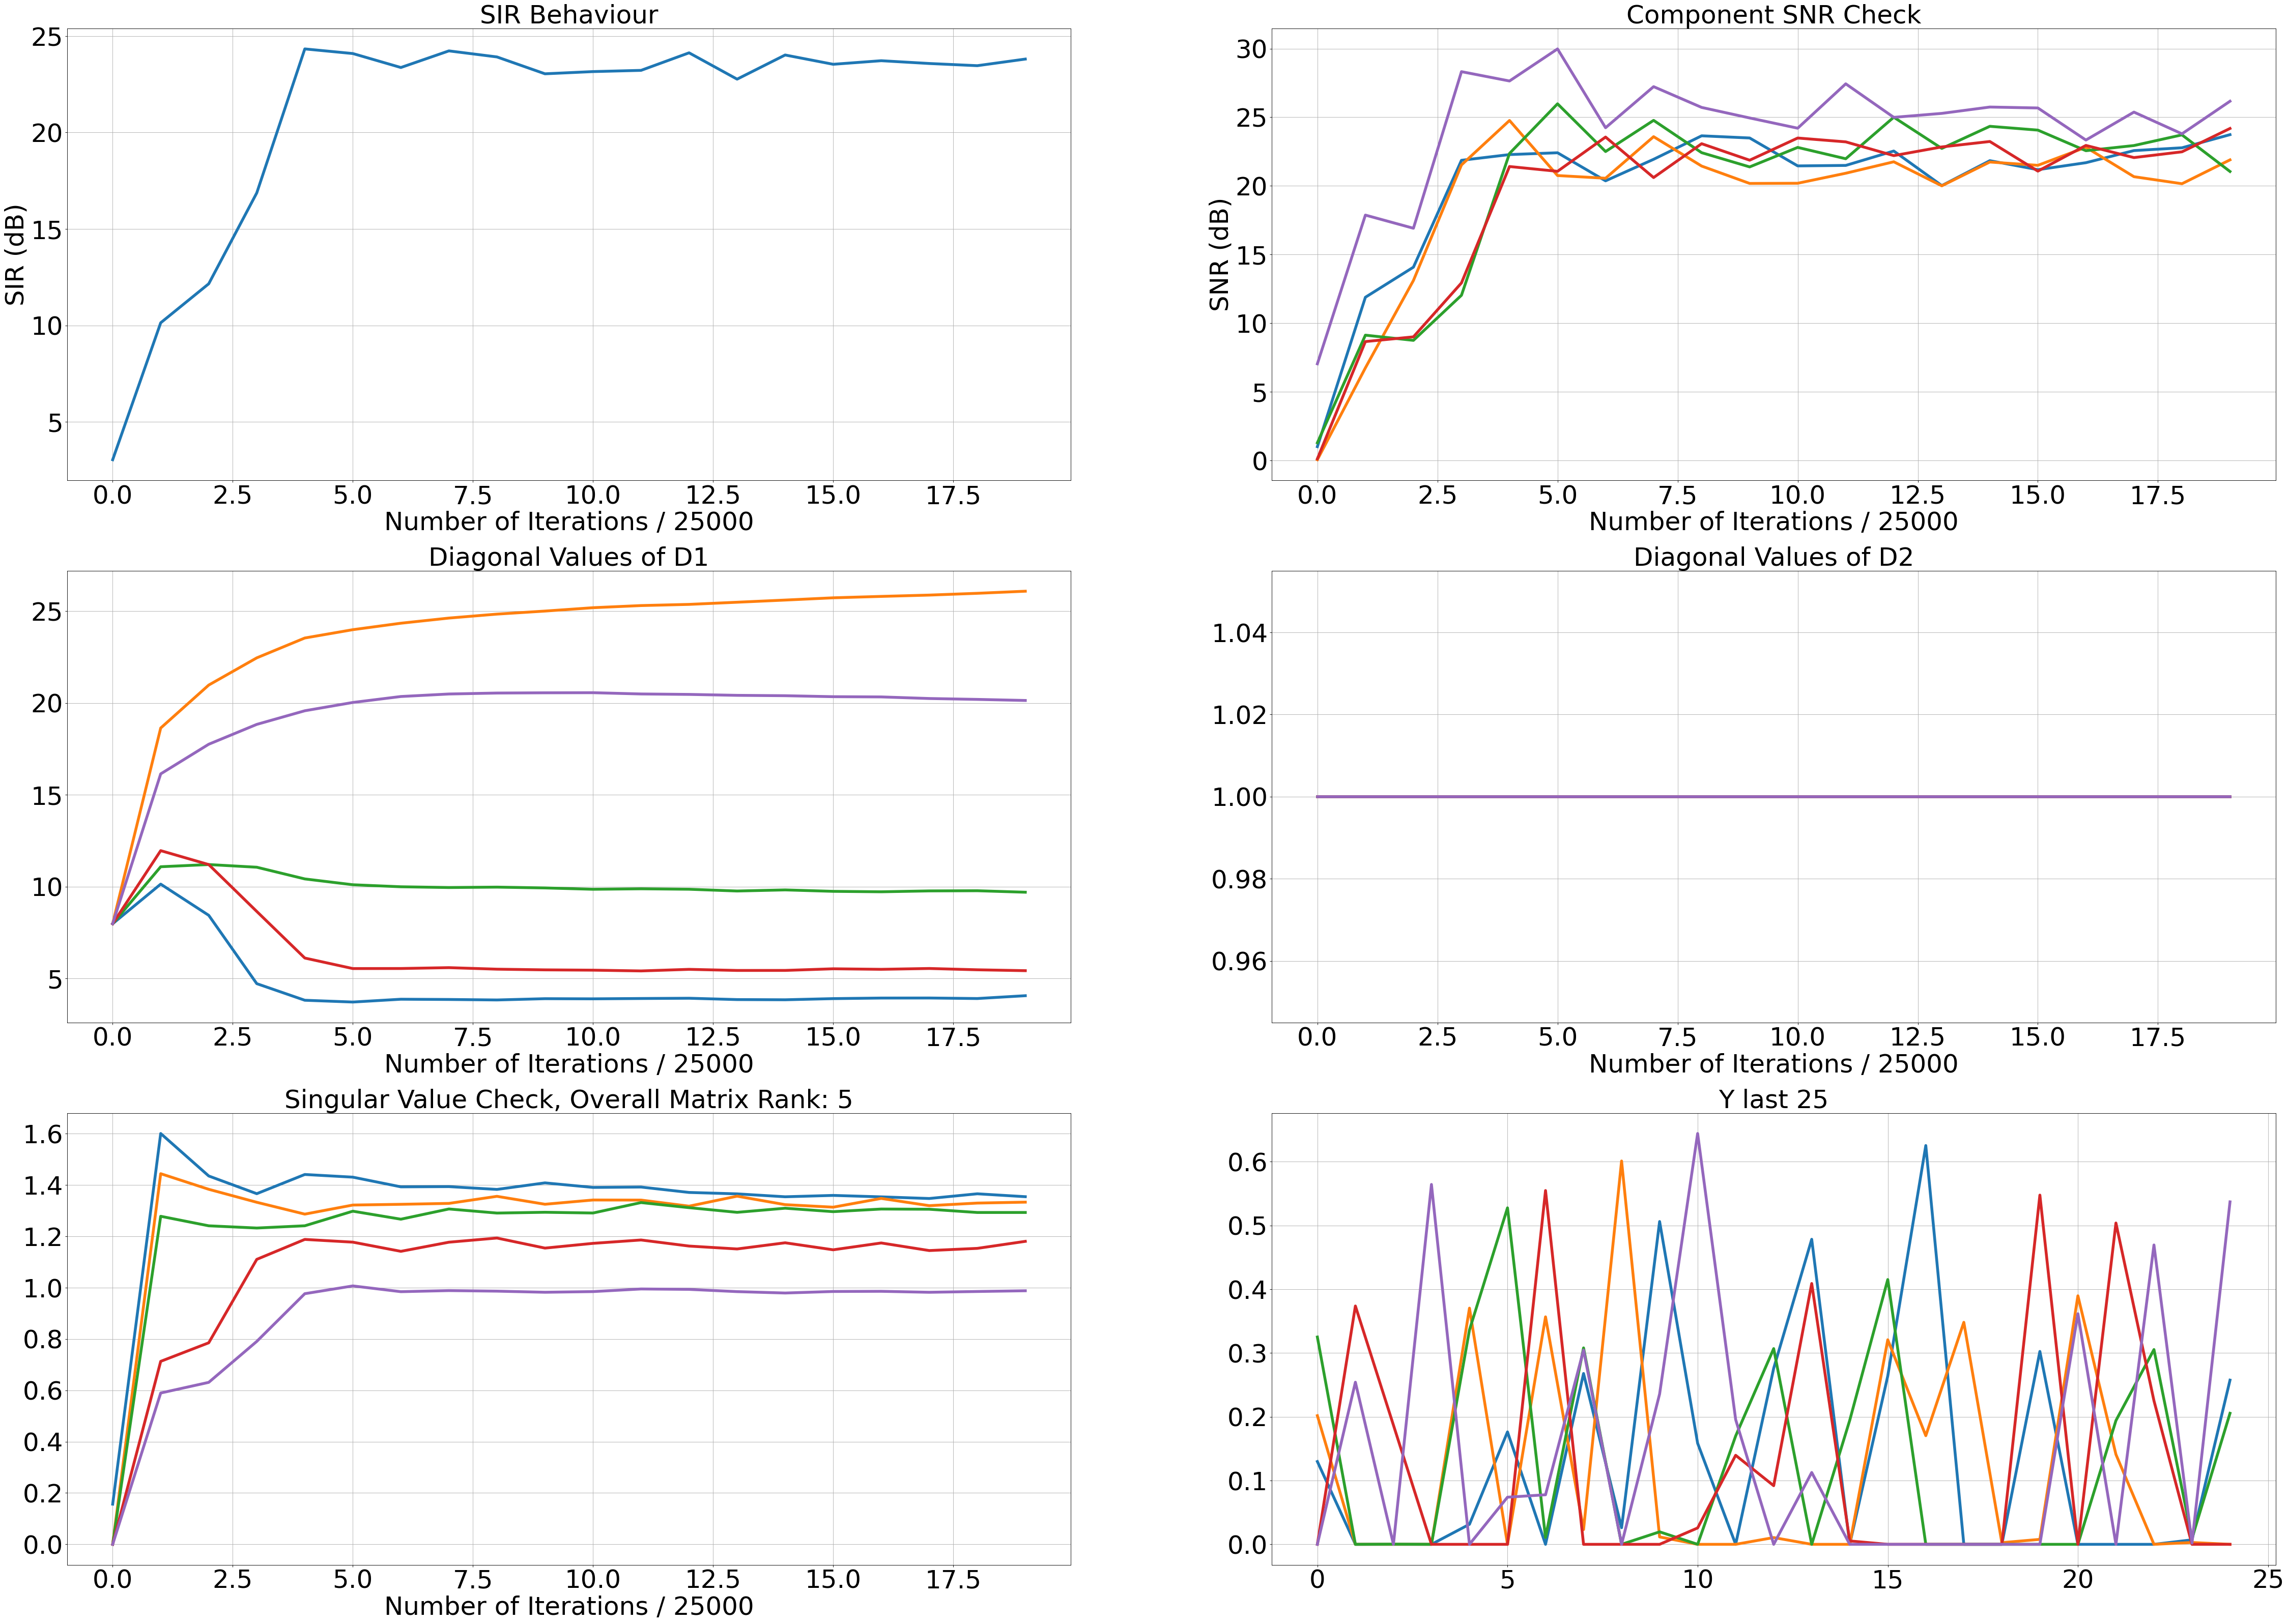

In [5]:
debug_iteration_point = 25000

model = OnlineWSMBSS(
    s_dim=s_dim,
    x_dim=x_dim,
    h_dim=h_dim,
    gammaM_start=gammaM_start,
    gammaM_stop=gammaM_stop,
    gammaW_start=gammaW_start,
    gammaW_stop=gammaW_stop,
    beta=beta,
    zeta=zeta,
    muD=muD,
    WScalings=WScalings,
    DScalings=LayerGains,
    LayerMinimumGains=LayerMinimumGains,
    LayerMaximumGains=LayerMaximumGains,
    neural_OUTPUT_COMP_TOL=OUTPUT_COMP_TOL,
    set_ground_truth=True,
    S=S,
    A=A,
)

model.fit_batch_nnsparse(
    X,
    n_epochs=1,
    neural_lr_start=0.5,
    neural_lr_stop=0.2,
    synaptic_lr_decay_divider=1,
    debug_iteration_point=debug_iteration_point,
    plot_in_jupyter=True,
)

# Visualize SNR Convergence of Each Source Component

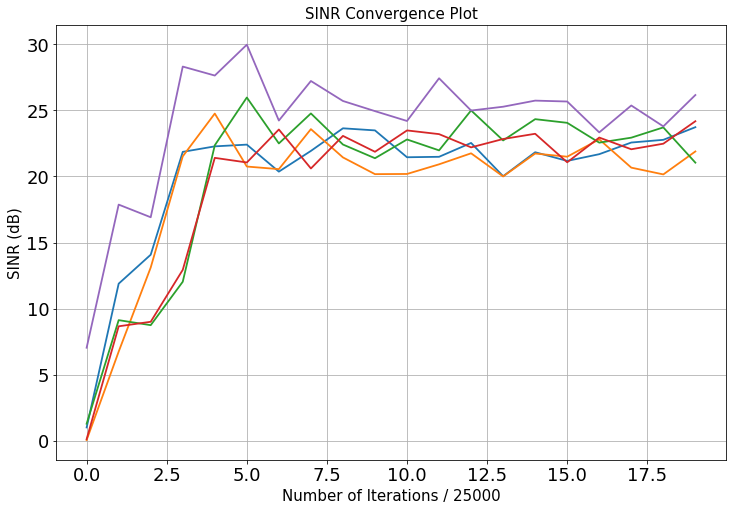

In [6]:
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
plot_convergence_plot(
    model.SNR_list,
    xlabel="Number of Iterations / {}".format(debug_iteration_point),
    ylabel="SINR (dB)",
    title="SINR Convergence Plot",
    colorcode=None,
    linewidth=1.8,
)

# Calculate Resulting Component SNRs and Overall SINR

In [7]:
Wf = model.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [23.8302682  20.55408867 22.27710824 24.6763639  26.33627081]

Overall SINR : 23.774611890074965


In [8]:
Szeromean = S - S.mean(axis=1).reshape(-1, 1)
Wf = model.compute_overall_mapping(return_mapping=True)
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis=1).reshape(-1, 1)
Y_ = model.signed_and_permutation_corrected_sources(Szeromean, Yzeromean)
coef_ = ((Y_ * Szeromean).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Szeromean, Y_)))

SINRwsm = 10 * np.log10(CalculateSINRjit(Y_, Szeromean)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [22.73252583 19.78303076 21.39611205 25.76639099 27.61359422]

Overall SINR : 22.587387550273654


# Vizualize Extracted Signals Compared to Original Sources

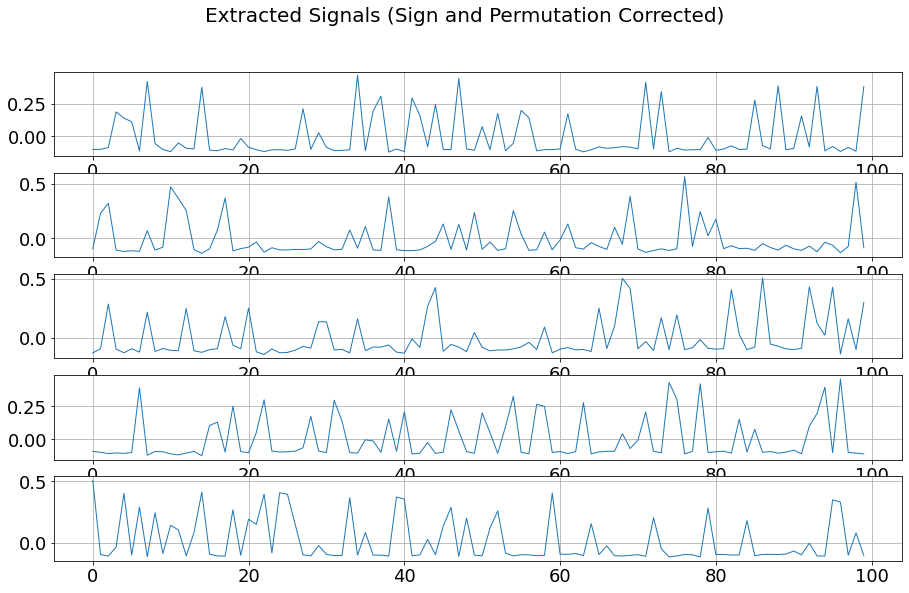

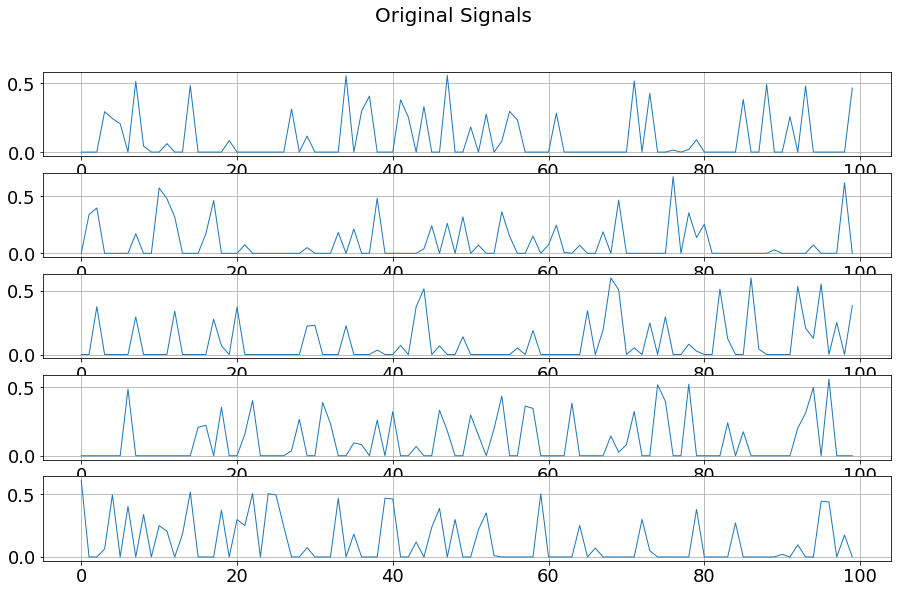

In [9]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)

In [10]:
# import mir_eval

In [11]:
# S.shape, Y_.shape

In [12]:
# mir_eval.separation.bss_eval_sources(S, Y_, compute_permutation=True)